In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis
import time
import traceback
#import scipy.linregress 

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)



Qubit(IQ_angle=60, RO_LO=6.6247, qubit_id=q1, ef_time=44, qubit_thr=[-10000, -600], ro_dur=5000, ge_ssm=-0.1144, ROIF=0.10268999999999995, ef_ssm=-0.2568, ef_half_time=25, ef_amp=1.49, ro_amp=0.35, ro_freq=6.72739, RO_IF=None, mixer_offset_ge=2.5, RO_LO_pwr=16, ef_half_amp=1.31, ge_time=77, mixer_offset_ef=6, ge_amp=1.01)
Qubit(IQ_angle=25, RO_LO=6.6247, qubit_id=q2, ef_time=None, qubit_thr=[-10000, 1900], ro_dur=5000, ge_ssm=-0.154, ROIF=0.030840000000000423, ef_ssm=-0.2962, ef_half_time=None, ef_amp=1, ro_amp=0.45, ro_freq=6.65554, RO_IF=None, mixer_offset_ge=None, RO_LO_pwr=16, ef_half_amp=None, ge_time=74, mixer_offset_ef=None, ge_amp=0.4)


In [3]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.52
    # if J is in units of rad/micros
J_to_a = 1 / a_to_J
#drive_amp=1.49
# # print(f"drive_amp 1.49:J={drive_amp*a_to_J}")
drive_amp = 0.285*J_to_a #0.285 EP

In [4]:
def run_rabi_tomo(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    state:str,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    
    # Run the experiment
    tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp=drive_amp,
        tomo_comp=tomography,
        state_comp=state,
    )

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

def scale_data(df_prob:dict):
    # max_normalized_f = normalized_f.max()
    # a=1/(max_normalized_f-normalized_f[0])
    # b=-a*normalized_f[0]
 
    normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
    normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
    a=1.0541512371671289
    b=-0.015033822333299638
    P_f_scaled=normalized_f# a*normalized_f+b
    P_e_scaled=normalized_e#1-P_f_scaled
    return P_f_scaled, P_e_scaled
    
    

In [5]:
def run_full_tomography(state: str,
                        q1, q2,
                        general_vals_dict,
                        reps=2000,
                        sweep_time=250,
                        swap_freq=-0.0194,
                        num_steps=101,
                        out_dir="tomography_data",
                        overwrite=False):
    """
    Runs (or loads) z, x, y tomography for a given `state`, saves each df_prob to a .pkl,
    then loads them all, scale_data's them, and returns a combined df_tomo.
    """
    # ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    # derived parameters
    swap_time = 0.5 * 7 / abs(swap_freq)

    axes = ["z", "x", "y"]
    df_probs = {}

    for tomo in axes:
        fname = f"{state}_prob_{tomo}.pkl"
        path = os.path.join(out_dir, fname)

        # 1) if file exists and not overwriting, load it
        if os.path.exists(path) and not overwrite:
            with open(path, "rb") as f:
                df_prob = pickle.load(f)
            print(f"[LOAD] {tomo}-tomography data from {path}")
        else:
            # 2) otherwise run the experiment
            
            df_prob, _, _ = run_rabi_tomo(
                q1=q1,
                q2=q2,
                general_vals_dict=general_vals_dict,
                num_steps=num_steps,
                sweep_time=sweep_time,
                swap_freq=swap_freq,
                swap_time=swap_time,
                reps=reps,
                tomography=tomo,
                state=state
            )
            

            # 3) save it for future runs
            with open(path, "wb") as f:
                pickle.dump(df_prob, f)
            print(f"[SAVE] {tomo}-tomography data to {path}")

        df_probs[tomo] = df_prob

    # 4) all three are now guaranteed to be in df_probs; scale them
    P_f = {}
    P_e = {}
    for tomo in axes:
        P_f[tomo], P_e[tomo] = scale_data(df_probs[tomo])

    # 5) assemble the final DataFrame
    df_tomo = pd.DataFrame(
        {
            "P_f_tomo_z": P_f["z"],
            "P_e_tomo_z": P_e["z"],
            "P_f_tomo_x": P_f["x"],
            "P_e_tomo_x": P_e["x"],
            "P_f_tomo_y": P_f["y"],
            "P_e_tomo_y": P_e["y"],
        },
        index=df_probs["z"].index,
    )

    return df_tomo

def load_and_build_df_tomo(state, out_dir="tomography_data"):
    # load the three df_prob pickles
    df_probs = {}
    for tomo in ["z","x","y"]:
        path = os.path.join(out_dir, f"{state}_prob_{tomo}.pkl")
        with open(path, "rb") as f:
            df_probs[tomo] = pickle.load(f)

    # scale each
    P_f = {};  P_e = {}
    for tomo in ["z","x","y"]:
        P_f[tomo], P_e[tomo] = scale_data(df_probs[tomo])

    # assemble df_tomo
    return pd.DataFrame({
        "P_f_tomo_z": P_f["z"],
        "P_f_tomo_x": P_f["x"],
        "P_f_tomo_y": P_f["y"],
        "P_e_tomo_z": P_e["z"],
        "P_e_tomo_x": P_e["x"],
        "P_e_tomo_y": P_e["y"],
    }, index=df_probs["z"].index)   

In [ ]:
state="e"
reps=10000
sweep_time=40000
swap_freq=-0.0194
num_steps=51

# Main loop: if an error occurs, print it, wait, and restart
while True:
    try:
        df_tomo = run_full_tomography(state=state,
                        q1=q1, 
                        q2=q2,
                        general_vals_dict=general_vals_dict,
                        reps=reps,
                        sweep_time=sweep_time,
                        swap_freq=swap_freq,
                        num_steps=num_steps,
                        out_dir="tomography_data",
                        overwrite=False)
        break  # Exit loop when measurements complete successfully
    except Exception as e:
        print("An error occurred:")
        traceback.print_exc()
        print("Restarting in 5 seconds...")
        time.sleep(5)


[LOAD] z-tomography data from tomography_data\f_prob_z.pkl
[LOAD] x-tomography data from tomography_data\f_prob_x.pkl
[LOAD] y-tomography data from tomography_data\f_prob_y.pkl


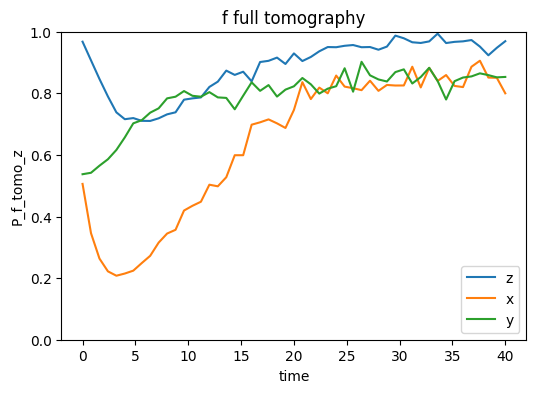

In [7]:
# suppose df_tomo is your DataFrame with time as its index
df_plot = df_tomo.reset_index().rename(columns={'index':'time'})

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_plot, x="time", y="P_f_tomo_z", label="z")
sns.lineplot(data=df_plot, x="time", y="P_f_tomo_x", label="x")
sns.lineplot(data=df_plot, x="time", y="P_f_tomo_y", label="y")
plt.title(f"{state} full tomography")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [8]:
# csv_filename = f"{state}_full_tomography_J35.csv"

# # save to CSV (no extra index column)
# df_plot.to_csv(csv_filename, index=False)

# print(f"Data saved to {csv_filename}")

In [9]:
# # Loop over each state and plot separately
# for state in ["e", "f", "x"]:
#     # 1) load & build
#     df_tomo = load_and_build_df_tomo(state)

#     # 2) turn index into a time column
#     df_plot = df_tomo.reset_index().rename(columns={'index':'time'})

#     # 3) plot z, x, y P_f curves
#     plt.figure(figsize=(6, 4))
#     sns.lineplot(data=df_plot, x="time", y="P_f_tomo_z", label="z")
#     sns.lineplot(data=df_plot, x="time", y="P_f_tomo_x", label="x")
#     sns.lineplot(data=df_plot, x="time", y="P_f_tomo_y", label="y")
#     plt.title(f"{state} full tomography (P_f)")
#     plt.xlabel("time")
#     plt.ylim(0, 1)
#     plt.legend(title="axis")
#     plt.show()

In [10]:
df_tomo_e = load_and_build_df_tomo("e")
df_tomo_f = load_and_build_df_tomo("f")
df_tomo_x = load_and_build_df_tomo("x")
P_f= (df_tomo_e["P_f_tomo_z"]+1-df_tomo_f["P_f_tomo_z"])/2
plt.plot(P_f)




FileNotFoundError: [Errno 2] No such file or directory: 'tomography_data\\e_prob_z.pkl'

In [ ]:
df_tomo_e

,P_f_tomo_z,P_f_tomo_x,P_f_tomo_y,P_e_tomo_z,P_e_tomo_x,P_e_tomo_y
0.000,0.014217,0.487342,0.536210,0.985783,0.512658,0.463790
0.003,0.023219,0.636489,0.481609,0.976781,0.363511,0.518391
0.006,0.074251,0.678361,0.497188,0.925749,0.321639,0.502812
0.009,0.103556,0.800898,0.512233,0.896444,0.199102,0.487767
0.012,0.191006,0.842957,0.474947,0.808994,0.157043,0.525053
0.015,0.277850,0.916787,0.524386,0.722150,0.083213,0.475614
0.018,0.348989,0.947140,0.477522,0.651011,0.052860,0.522478
0.021,0.500000,0.970074,0.520497,0.500000,0.029926,0.479503
0.024,0.550375,0.966083,0.497538,0.449625,0.033917,0.502462
0.027,0.698813,0.946209,0.507289,0.301187,0.053791,0.492711


In [ ]:
# reps = 5000
# sweep_time = 80
# swap_freq = -0.0194
# swap_time =   0.5 * 7 / abs(swap_freq)
# J = 10
# num_steps = 51
# tomography = "z"
# df_prob, df_pop, values = run_rabi_tomo(
#     q1=q1,
#     q2=q2,
#     general_vals_dict=general_vals_dict,
#     num_steps=num_steps,
#     sweep_time=sweep_time,
#     swap_freq=swap_freq,
#     swap_time=swap_time,
#     reps=reps,
#     tomography=tomography,
#     state="e",
# )


In [ ]:
# plt.figure(dpi=150)
# sns.lineplot(data=df_prob, x="time", y="P_f", label="f")
# sns.lineplot(data=df_prob, x="time", y="P_e", label="e")
# sns.lineplot(data=df_prob, x="time", y="P_g", label="g")
# plt.title(f"{tomography} tomography")
# plt.legend()
# plt.ylim(0, 1)
# plt.show()
# plt.figure(dpi=150)
# normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
# normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
# sns.lineplot(data=normalized_f, label="f")
# # sns.lineplot(data=normalized_e, label="e")
# plt.title(f"Normalized f and e populations, Tomo = {tomography}")

# plt.ylim(0, 1)
# plt.legend()
# plt.show()

In [ ]:
# def run_rabi_tomo_phase(
#     q1,
#     q2,
#     general_vals_dict,
#     num_steps: int,
#     sweep_time: float,
#     swap_freq: float,
#     swap_time: float,
#     reps: int,
#     tomography: str,
#     phase_start:float,
#     phase_stop:float,

# ):
#     """
#     Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
#     and processes the resulting IQ data to compute probabilities vs. time.

#     Returns:
#         df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
#                                 np.linspace(0, sweep_time/1000, num_steps)) and which has
#                                 columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
#                                 of the f, e, and g states respectively.
#     """
#     # Run the experiment
#     tomo.rabi_tomo_phase(
#         q1,
#         q2,
#         general_vals_dict,
#         num_steps=num_steps,
#         sweep_time=sweep_time,
#         swap_freq=swap_freq,
#         swap_time=swap_time,
#         drive_amp_J=0,
#         tomo_comp=tomography,
#         phase_start=phase_start,
#         phase_stop=phase_stop

    
#     )

#     wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
#     # Acquire the raw IQ data
#     values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
#     )

#     # Retrieve raw IQ data from the acquired values
#     I1_raw = values.rec_readout_1[0]
#     Q1_raw = values.rec_readout_1[1]
#     I2_raw = values.rec_readout_2[0]
#     Q2_raw = values.rec_readout_2[1]

#     # Build a DataFrame from the IQ data for classification
#     IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

#     # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
#     classified = classifier.classify(IQ_df)
#     states = classified["predicted"]
#     # Reshape the predicted states.
#     # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
#     #  where each row corresponds to a time step and holds all the state measurements for that step.)
#     states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
#     probabilties = classifier.probabilities(states_reshaped)
#     population = classifier.population(states_reshaped)

#     # Compute time values as the index for the DataFrame.
#     times = np.linspace(phase_start,phase_stop, num_steps)

#     # Build a DataFrame that holds the probability vs. time.
#     df_prob = pd.DataFrame(
#         {
#             "time": times,
#             "P_f": probabilties["P_f"],
#             "P_e": probabilties["P_e"],
#             "P_g": probabilties["P_g"],
#         },
#         index=times,
#     )

#     df_pop = pd.DataFrame(
#         {
#             "time": times,
#             "Pop_f": population["Pop_f"],
#             "Pop_e": population["Pop_e"],
#             "Pop_g": population["Pop_g"],
#         },
#         index=times,
#     )

#     return df_prob, df_pop, values

In [ ]:
# def sweep_amp_tomo_x(amp_list:list):
#     reps = 50000
#     sweep_time = 250
#     swap_freq = -0.0194
#     swap_time =   0.5 * 7 / abs(swap_freq)
#     J = 10
#     num_steps = 3
#     tomography = "y"
#     scale_matrix_inv = np.array([
#     [-0.00972053 , 1.00972053],
#     [ 1.00972053 ,-0.00972053]
#     ])
#     P_f = np.zeros(len(amp_list))
#     for i,amp in enumerate(amp_list):
#         q1.ef_half_amp_y =amp

#         # q1.ef_amp=0.05
#         # q1.ef_ssm=-0.2568
#         df_prob, df_pop, values = run_rabi_tomo(
#             q1=q1,
#             q2=q2,
#             general_vals_dict=general_vals_dict,
#             num_steps=num_steps,
#             sweep_time=sweep_time,
#             swap_freq=swap_freq,
#             swap_time=swap_time,
#             reps=reps,
#             tomography=tomography,
#         )
#         normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
#         normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
#         P_matrix = np.array([normalized_f[0],normalized_e[0]])
#         P_f[i]=np.matmul(scale_matrix_inv,P_matrix)[1]
#     return P_f
        


In [ ]:
# amp_start=1.3
# amp_stop=1.4
# amp_steps= 11
# amp_list = np.linspace(amp_start,amp_stop,amp_steps)
# P_f=sweep_amp_tomo_x(amp_list)

In [ ]:
# plt.figure(dpi=150)
# plt.plot(amp_list, P_f)

# plt.xlabel("ef_half_amp_x")
# plt.ylabel("P_f")
# plt.axhline(0.5, color="black", linestyle="--")
# plt.axvline(1.354, color="black", linestyle="--")
# plt.legend()
# plt.show()


In [ ]:
# # Define the list of y_ph values to sweep over
# x_ph_list = np.linspace(165,195, 41)  # Example list, replace with your actual values

# reps = 2000
# sweep_time = 1
# swap_freq = -0.0195
# swap_time = 0.5 * 6 / abs(swap_freq)
# J = 35
# num_steps =1
# tomography = "z"
# y_ph = 77
# # Define the folder to save results
# save_folder = "x_ph_sweep"
# os.makedirs(save_folder, exist_ok=True)

# # Define a checkpoint file to track progress
# checkpoint_file = os.path.join(save_folder, "checkpoint.txt")

# # Load the last completed y_ph value if the checkpoint file exists
# if os.path.exists(checkpoint_file):
#     with open(checkpoint_file, "r") as f:
#         last_completed_x_ph = float(f.read().strip())
# else:
#     last_completed_x_ph = None

# # Loop over the y_ph values
# for x_ph in x_ph_list:
#     # Skip already completed y_ph values
#     if last_completed_x_ph is not None and x_ph <= last_completed_x_ph:
#         print(f"Skipping x_ph = {x_ph} (already completed)")
#         continue

#     print(f"Running for x_ph = {x_ph}")

#     # Run the Rabi tomography simulation
#     df_prob, df_pop, values = run_rabi_tomo(
#         q1=q1,
#         q2=q2,
#         general_vals_dict=general_vals_dict,
#         num_steps=num_steps,
#         sweep_time=sweep_time,
#         swap_freq=swap_freq,
#         swap_time=swap_time,
#         reps=reps,
#         tomography=tomography,
#         J=J,
#         y_ph=y_ph,
#         x_tomo_ph= x_ph
#     )

#     # Save the df_prob dataframe
#     save_filename = os.path.join(save_folder, f"df_prob_x_ph_{x_ph}.csv")
#     df_prob.to_csv(save_filename, index=False)
#     print(f"Saved results for x_ph = {x_ph} to {save_filename}")

#     # Update the checkpoint file
#     with open(checkpoint_file, "w") as f:
#         f.write(str(x_ph))
#     print(f"Updated checkpoint to x_ph = {x_ph}")

# print("Sweep complete!")

In [ ]:
# import glob
# # Folder where your CSV files are saved
# save_folder = "x_ph_sweep"

# # Use glob to get all CSV files matching the pattern
# csv_files = glob.glob(os.path.join(save_folder, "df_prob_x_ph_*.csv"))

# x_ph_values = []
# norm_pf_values = []

# # Loop over each CSV file
# for file in csv_files:
#     # Extract the x_ph value from the filename.
#     # Assuming the filename format is: "df_prob_x_ph_{x_ph}.csv"
#     basename = os.path.basename(file)
#     # Remove the prefix and suffix to get the numeric part
#     # E.g., from "df_prob_x_ph_180.0.csv" extract "180.0"
#     x_ph_str = basename.replace("df_prob_x_ph_", "").replace(".csv", "")
#     x_ph_val = float(x_ph_str)
    
#     # Load the CSV file into a DataFrame
#     df_prob = pd.read_csv(file)
    
#     # Calculate the normalized P_f = P_f / (P_f + P_e)
#     # Assuming there's one row in the DataFrame
#     P_f = df_prob["P_f"].iloc[0]
#     P_e = df_prob["P_e"].iloc[0]
#     norm_pf = P_f / (P_f + P_e)
    
#     # Store the values
#     x_ph_values.append(x_ph_val)
#     norm_pf_values.append(norm_pf)

# # Sort the data by x_ph values (important for plotting a smooth curve)
# sorted_indices = sorted(range(len(x_ph_values)), key=lambda i: x_ph_values[i])
# x_ph_sorted = [x_ph_values[i] for i in sorted_indices]
# norm_pf_sorted = [norm_pf_values[i] for i in sorted_indices]

# # Plot normalized P_f versus x_ph
# plt.figure(figsize=(8, 6))
# plt.plot(x_ph_sorted, norm_pf_sorted, 'o-', label="Normalized $P_f$")
# plt.xlabel("$x_{ph}$")
# plt.ylabel("Normalized $P_f$")
# plt.title("Normalized $P_f$ vs. $x_{ph}$")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# from scipy.optimize import curve_fit
# import analysis.fit_functions as fit_funcs  # This package should contain sine_decay

# # Extract the time values from df_prob
# time = df_prob["time"].values

# # Compute normalized populations: P_f_norm and P_e_norm
# normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
# normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])

# # Define an initial guess for the sine_decay parameters:
# # Parameters: freq_Hz, gamma, amplitude, phase_deg, offset
# initial_guess_e = [1.0, 0.1, 0.5, 0.0, 0.1]
# initial_guess_f = [1.0, 0.1, 0.5, 180, 0.1]

# # Perform curve fit for normalized f data
# popt_f, pcov_f = curve_fit(fit_funcs.sine_decay, time, normalized_f.values, p0=initial_guess_f)
# # Compute the fitted curve for normalized f
# fitted_f = fit_funcs.sine_decay(time, *popt_f)

# # Perform curve fit for normalized e data
# popt_e, pcov_e = curve_fit(fit_funcs.sine_decay, time, normalized_e.values, p0=initial_guess_e)
# # Compute the fitted curve for normalized e
# fitted_e = fit_funcs.sine_decay(time, *popt_e)

# # Plot the data and the fitted curves
# plt.figure(dpi=150)
# sns.lineplot(x=time, y=normalized_f, label="Normalized f (data)")
# sns.lineplot(x=time, y=fitted_f, label="Normalized f (fit)", linestyle="--")
# sns.lineplot(x=time, y=normalized_e, label="Normalized e (data)")
# sns.lineplot(x=time, y=fitted_e, label="Normalized e (fit)", linestyle="--")
# plt.xlabel("Time")
# plt.ylabel("Normalized Population")
# plt.title(f"Normalized f and e populations, Tomo = {tomography}")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Optionally, print the fitted parameters
# print("Fitted parameters for normalized f:")
# print(" freq_Hz =", popt_f[0])
# print(" gamma   =", popt_f[1])
# print(" amplitude =", popt_f[2])
# print(" phase_deg =", popt_f[3])
# print(" offset  =", popt_f[4])
# print("\nFitted parameters for normalized e:")
# print(" freq_Hz =", popt_e[0])
# print(" gamma   =", popt_e[1])
# print(" amplitude =", popt_e[2])
# print(" phase_deg =", popt_e[3])
# print(" offset  =", popt_e[4])